In [11]:
import librosa
import numpy as np
import scipy
import librosa.display
import librosa.decompose
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Audio

In [2]:
d = {}

pn = r'A:\Dev\NF_Prj_MIMII_Dataset\dataset\6dB\pump\id_04\normal\00000000.wav'
pa = r'A:\Dev\NF_Prj_MIMII_Dataset\dataset\6dB\pump\id_04\abnormal\00000000.wav'    
d['pump'] = {'n': librosa.load(pn, sr=None, mono=False),
             'a': librosa.load(pa, sr=None, mono=False)}
pn = r'A:\Dev\NF_Prj_MIMII_Dataset\dataset\6dB\fan\id_00\normal\00000000.wav'
pa = r'A:\Dev\NF_Prj_MIMII_Dataset\dataset\6dB\fan\id_00\abnormal\00000000.wav'    
d['fan'] = {'n': librosa.load(pn, sr=None, mono=False),
             'a': librosa.load(pa, sr=None, mono=False)}
pn = r'A:\Dev\NF_Prj_MIMII_Dataset\dataset\6dB\slider\id_02\normal\00000000.wav'
pa = r'A:\Dev\NF_Prj_MIMII_Dataset\dataset\6dB\slider\id_02\abnormal\00000000.wav'    
d['slider'] = {'n': librosa.load(pn, sr=None, mono=False),
             'a': librosa.load(pa, sr=None, mono=False)}
pn = r'A:\Dev\NF_Prj_MIMII_Dataset\dataset\6dB\valve\id_06\normal\00000000.wav'
pa = r'A:\Dev\NF_Prj_MIMII_Dataset\dataset\6dB\valve\id_06\abnormal\00000000.wav'    
d['valve'] = {'n': librosa.load(pn, sr=None, mono=False),
             'a': librosa.load(pa, sr=None, mono=False)}

sr = d['pump']['n'][1]

In [7]:
np.linspace(0,len(d['pump']['n'][0][0])/sr,len(d['pump']['n'][0][0]))

array([0.00000000e+00, 6.25003906e-05, 1.25000781e-04, ...,
       9.99987500e+00, 9.99993750e+00, 1.00000000e+01])

In [9]:
y = d['pump']['n'][0][0]

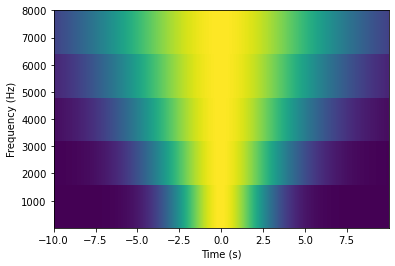

In [31]:
# parameters (in Hz)

srate = sr
times = np.linspace(0,len(d['pump']['n'][0][0])/sr,len(d['pump']['n'][0][0]))
numFrex = 6
minFreq =  2
maxFreq = srate/2
npntsTF = 1000 # this one's in points

# frequencies in Hz
frex  = np.linspace(minFreq,maxFreq,numFrex)

# wavelet widths (FWHM in seconds)
fwhms = np.linspace(5,15,numFrex)


# time points to save for plotting
tidx = np.arange(1,len(times),npntsTF)


# setup wavelet and convolution parameters
wavet = np.arange(-10,10,1/srate)
halfw = int(np.floor(len(wavet)/2))
nConv = len(times) + len(wavet) - 1


# create family of Morlet wavelets
cmw = np.zeros((len(wavet),numFrex),dtype=complex)
# loop over frequencies and create wavelets
for fi in range(0,numFrex):
    cmw[:,fi] = np.exp(2*1j*np.pi*frex[fi]*wavet)*np.exp(-(4*np.log(2)*wavet**2)/fwhms[fi]**2)
    
# plot them
plt.pcolormesh(wavet,frex,np.abs(cmw).T,vmin=0,vmax=1)
plt.xlabel('Time (s)'), plt.ylabel('Frequency (Hz)')
plt.show()

In [32]:
## run convolution

# initialize time-frequency matrix
tf  = np.zeros((len(frex),len(tidx)))
tfN = np.zeros((len(frex),len(tidx)))

# baseline time window for normalization
basetidx = [0,0]
basetidx[0] = np.argmin( (times--1000)**2 )
basetidx[1] = np.argmin( times**2 )
basepow     = np.zeros(numFrex)


# spectrum of data
dataX = scipy.fftpack.fft(y,nConv)

# loop over frequencies for convolution
for fi in range(0,numFrex):
    
    # create wavelet
    waveX = scipy.fftpack.fft( cmw[:,fi],nConv )
    waveX = waveX/np.max(waveX) # normalize
    
    # convolve
    as1 = scipy.fftpack.ifft( waveX*dataX )
    # trim
    as1 = as1[halfw:-halfw]
    
    # power time course at this frequency
    powts = np.abs(as1)**2
    
    # baseline (pre-quake)
    basepow[fi] = np.mean(powts[range(basetidx[0],basetidx[1])])
    
    tf[fi,:]  = 10*np.log10( powts[tidx] )
    tfN[fi,:] = 10*np.log10( powts[tidx]/basepow[fi] )

C:\ProgramData\Anaconda3\envs\mimiibaseTF2GPU\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\envs\mimiibaseTF2GPU\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
## show time-frequency maps

# "raw" power
plt.subplot(211)
plt.pcolormesh(times[tidx],frex,tf,vmin=-150,vmax=-70)
plt.xlabel('Time'), plt.ylabel('Frequency (Hz)')
plt.title('"Raw" time-frequency power')

# pre-quake normalized power
plt.subplot(212)
plt.pcolormesh(times[tidx],frex,tfN,vmin=-15,vmax=15)
plt.xlabel('Time'), plt.ylabel('Frequency (Hz)')
plt.title('"Raw" time-frequency power')
plt.show()


## normalized and non-normalized power
plt.subplot(211)
plt.plot(frex,np.mean(tf,axis=1),'ks-')
plt.xlabel('Frequency (Hz)'), plt.ylabel('Power (10log_{10})')
plt.title('Raw power')

plt.subplot(212)
plt.plot(frex,np.mean(tfN,axis=1),'ks-')
plt.xlabel('Frequency (Hz)'), plt.ylabel('Power (norm.)')
plt.title('Pre-quake normalized power')
plt.show()

In [ ]:
#https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.signal.cwt.html

In [24]:
widths = np.arange(1, 200)
cwtmatr = scipy.signal.cwt(y, scipy.signal.morlet, widths)

C:\ProgramData\Anaconda3\envs\mimiibaseTF2GPU\lib\site-packages\scipy\signal\wavelets.py:364: ComplexWarning: Casting complex values to real discards the imaginary part
  mode='same')


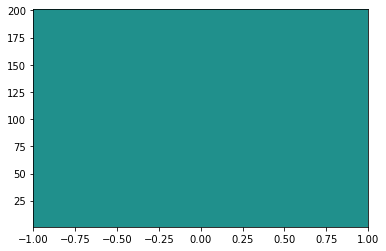

In [30]:
plt.imshow(cwtmatr**10, extent=[-1, 1, 1, 201], aspect='auto',
 vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())

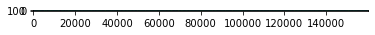

In [26]:
plt.imshow(cwtmatr)

In [25]:
cwtmatr

array([[ 5.77619099e-04,  5.57424441e-04, -1.70745140e-04, ...,
        -4.52953920e-04,  6.47813918e-05,  1.36405851e-03],
       [ 2.76421339e-03,  3.65718918e-03,  1.13861250e-03, ...,
        -4.61298663e-03,  2.46624523e-03,  7.45816587e-03],
       [ 2.75549256e-03,  5.12016289e-03,  2.73030280e-03, ...,
        -8.02326930e-03,  4.35337626e-03,  1.05830459e-02],
       ...,
       [ 7.50141288e-03,  9.83948982e-03, -1.43399353e-03, ...,
        -3.24548507e-03,  4.31698036e-04,  3.40894802e-03],
       [ 7.50322522e-03,  9.86698731e-03, -1.41847393e-03, ...,
        -3.35347588e-03,  4.21107320e-04,  3.50932236e-03],
       [ 7.50476732e-03,  9.89428510e-03, -1.40280589e-03, ...,
        -3.46108203e-03,  4.10536052e-04,  3.60936208e-03]])